# Predict change in loanword integration
Let's see whether loanwords become more/less likely to be integrated over time, using (1) long-term sparse data and (2) short-term dense data.

## Visualize change
We've collected long-term counts of loanwords from Twitter [here](../data_processing/get_loanword_integration_counts_over_time.sh). 
Let's visualize these counts to determine whether there is consistent change.

In [2]:
import pandas as pd
import re
import os
from datetime import datetime
# load data
def load_count_data(data_file):
    data = pd.read_csv(data_file, sep=',', header=None)
    data.columns= ['loanword', 'integrated_verb', 'light_verb', 'file_name']
    data.dropna(axis=0, inplace=True)
    # get date
    date_fmt = '%b-%d-%y'
    data = data.assign(**{
        'date' : data.loc[:, 'file_name'].apply(lambda x: datetime.strptime('-'.join(x.split('-')[1:4]), date_fmt))
    })
    # get year for more coarse-grained analysis
    data = data.assign(**{
        'date_year' : data.loc[:, 'date'].apply(lambda x: x.year)
    })
    return data
data_dir = '../../output/twitter_word_count_data/'
file_matcher = re.compile('LOANWORD\=[a-z]+_twitter_counts.txt')
data_files = list(filter(lambda x: file_matcher.search(x) is not None, os.listdir(data_dir)))
data_files = list(map(lambda x: os.path.join(data_dir, x), data_files))
count_data = list(map(lambda x: load_verb_count_data(x), data_files))
count_data = pd.concat(count_data, axis=0)
count_data.sort_values(['loanword', 'date'], inplace=True, ascending=True)
display(count_data.head())

,loanword,integrated_verb,light_verb,file_name,date,date_year
18,access,2,0,tweets-Feb-15-14-00-00,2014-02-15,2014
41,access,0,0,tweets-Mar-15-14-00-00,2014-03-15,2014
0,access,0,0,tweets-Apr-15-14-00-00,2014-04-15,2014
47,access,0,0,tweets-May-15-14-00-00,2014-05-15,2014
35,access,1,0,tweets-Jun-15-14-00-00,2014-06-15,2014


Compute integration rate.

In [3]:
def compute_integrated_rate(data):
    integrated_rate = data.loc[:, 'integrated_verb'].sum() / data.loc[:, ['integrated_verb', 'light_verb']].sum(axis=1).sum()
    return integrated_rate
loanword_var = 'loanword'
date_var = 'date_year'
integrated_rate_data = count_data.groupby([loanword_var, date_var]).apply(lambda x: compute_integrated_rate(x))
integrated_rate_data = integrated_rate_data.reset_index(inplace=False).rename(columns={0 : 'integrated_rate'})
print(integrated_rate_data)

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


    loanword  date_year  integrated_rate
0     access       2014         1.000000
1     access       2015         1.000000
2     access       2016         0.952381
3     access       2017         1.000000
4     access       2018         1.000000
..       ...        ...              ...
709      zap       2015         0.628571
710      zap       2016         0.230769
711      zap       2017         0.384615
712      zap       2018         0.200000
713      zap       2019         0.190476

[714 rows x 3 columns]


Let's plot this out.

In [169]:
# plot everything separately, then together
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from math import ceil
def plot_data_all_words(data, word_var='loanword', time_var='date_year', y_var='integrated_rate'):
    N = data.loc[:, word_var].nunique()
    cols = 3
    rows = int(ceil(N / cols))
    f, axs = plt.subplots(rows, cols, figsize=(5*cols, 3*rows))
    for i, (word_i, data_i) in enumerate(data.groupby(word_var)):
        ax = axs[int(i / cols), i % cols]
        X = data_i.loc[:, date_var].values
        ax.plot(X, data_i.loc[:, y_var])
        ax.set_title(f'{word_i}')
        ax.set_ylabel(y_var)
    plt.tight_layout()
    plt.show()

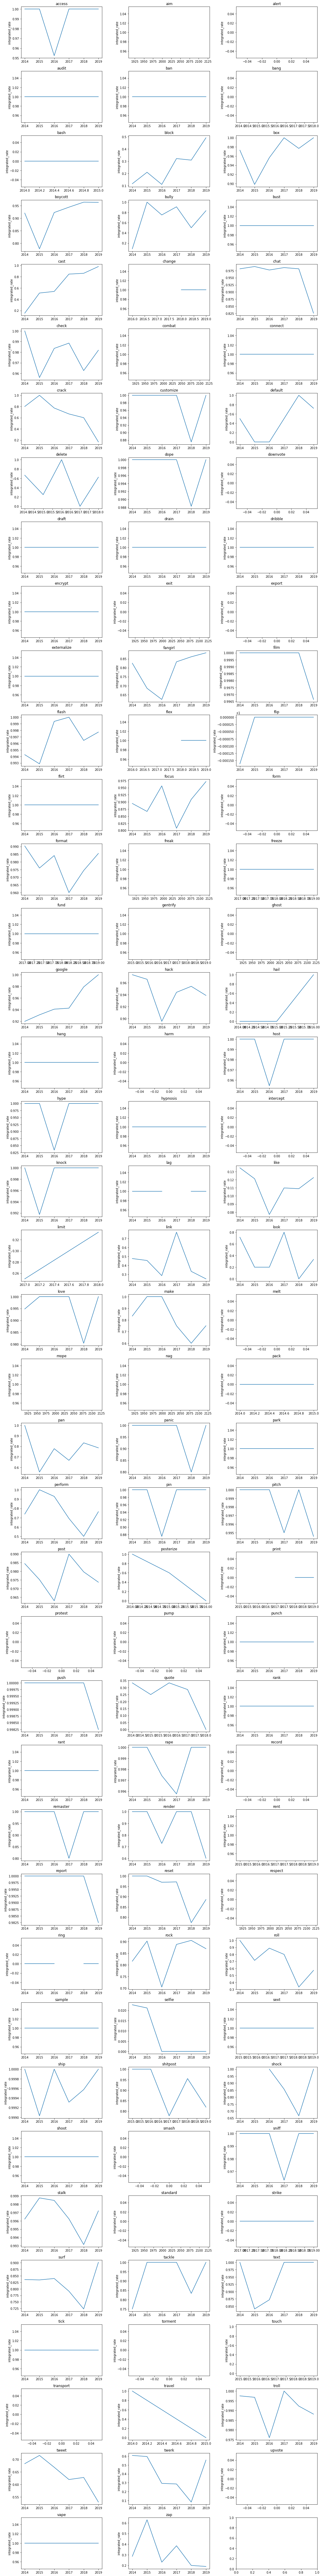

In [170]:
loanword_var = 'loanword'
date_var = 'date_year'
integrated_rate_var = 'integrated_rate'
plot_data_all_words(integrated_rate_data, word_var=loanword_var, time_var=date_var, y_var=integrated_rate_var)

Great! We actually see consistent growth for most of the valid cases (`block`, `box`, `boycott`, `cast`, `google`).

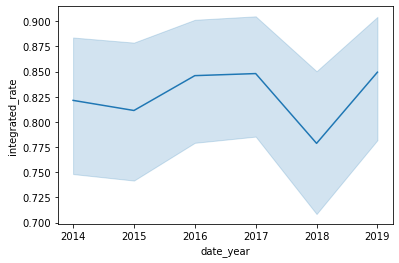

correl = 0.006 (p=8.868E-01)


In [171]:
# combined plot
import seaborn as sns
valid_integrated_rate_data = integrated_rate_data.dropna(axis=0)
# dummy variable
valid_integrated_rate_data = valid_integrated_rate_data.assign(**{'is_loanword' : 1})
sns.lineplot(x='date_year', y='integrated_rate', hue='is_loanword', data=valid_integrated_rate_data, legend=False)
plt.show()
# compute correlation
from scipy.stats import spearmanr, pearsonr
correl, p_val = pearsonr(valid_integrated_rate_data.loc[:, 'date_year'], valid_integrated_rate_data.loc[:, 'integrated_rate'])
print('correl = %.3f (p=%.3E)'%(correl, p_val))

Let's repeat this with per-month data and drop the NAN values.

In [172]:
loanword_var = 'loanword'
month_date_var = 'date'
monthly_integrated_rate_data = count_data.groupby([loanword_var, month_date_var]).apply(lambda x: compute_integrated_rate(x))
monthly_integrated_rate_data = monthly_integrated_rate_data.reset_index(inplace=False).rename(columns={0 : 'integrated_rate'})
monthly_integrated_rate_data.dropna(axis=0, inplace=True)
print(monthly_integrated_rate_data.head())

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


  loanword       date  integrated_rate
0   access 2014-02-15              1.0
4   access 2014-06-15              1.0
7   access 2014-09-15              1.0
8   access 2014-10-15              1.0
9   access 2014-11-15              1.0


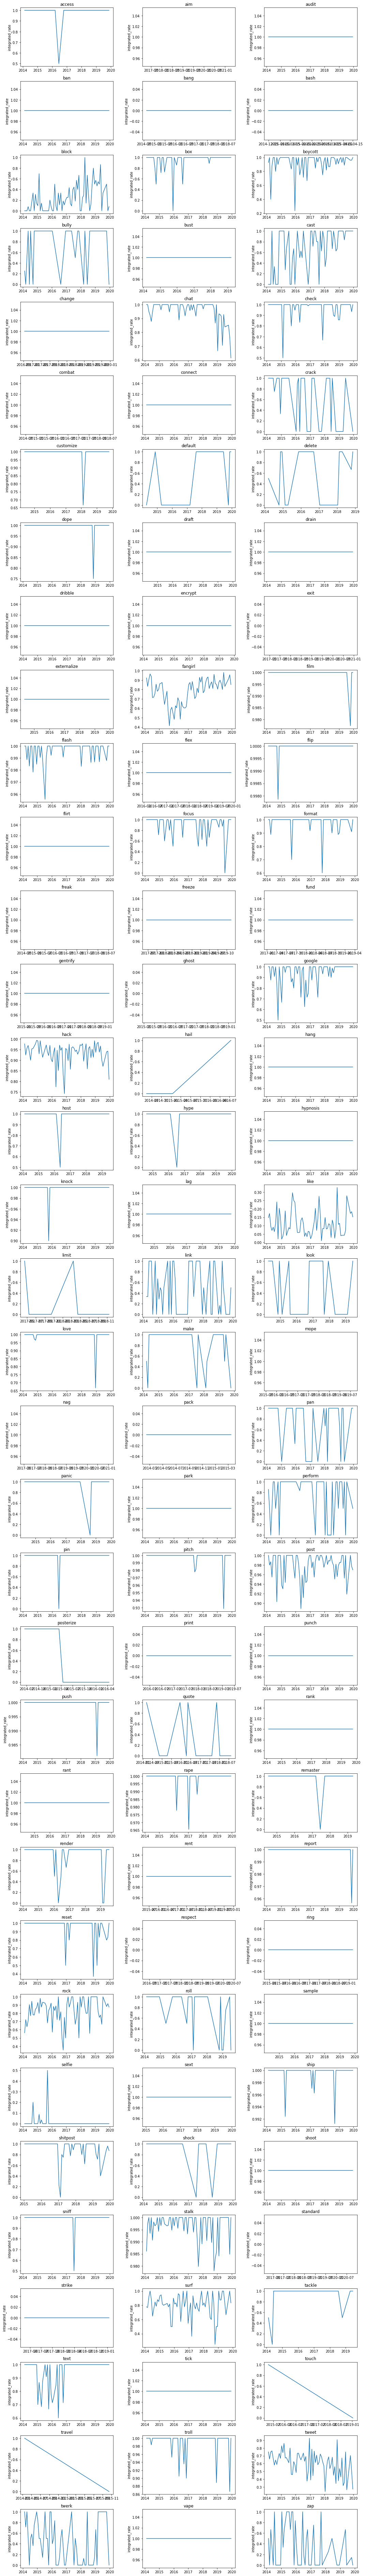

In [173]:
loanword_var = 'loanword'
date_var = 'date'
integrated_rate_var = 'integrated_rate'
plot_data_all_words(monthly_integrated_rate_data, word_var=loanword_var, time_var=date_var, y_var=integrated_rate_var)

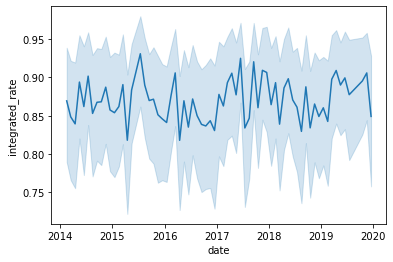

correl = 0.014 (p=3.723E-01)


In [174]:
# combined plot
# dummy variable
valid_monthly_integrated_rate_data = monthly_integrated_rate_data.assign(**{'is_loanword' : 1})
sns.lineplot(x='date', y='integrated_rate', hue='is_loanword', data=valid_monthly_integrated_rate_data, legend=False)
plt.show()
# compute correlation
from scipy.stats import spearmanr, pearsonr
correl, p_val = pearsonr(monthly_integrated_rate_data.loc[:, 'date'].apply(lambda x: x.timestamp()), monthly_integrated_rate_data.loc[:, 'integrated_rate'])
print('correl = %.3f (p=%.3E)'%(correl, p_val))

OK! We see a weak increase over time for monthly counts.

Let's restrict the data to only words with at least one light verb.

testing date var date


/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


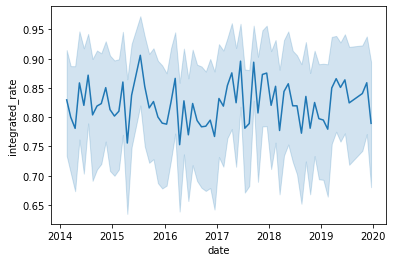

correl = 0.007 (p=6.869E-01)
testing date var date_year


/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


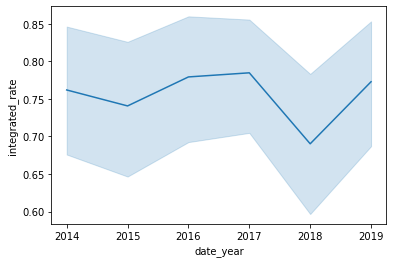

correl = -0.015 (p=7.769E-01)


In [175]:
word_var = 'loanword'
light_verb_word_counts = count_data.groupby(word_var).apply(lambda x: x.loc[:, 'light_verb'].sum()).sort_values(inplace=False, ascending=False)
min_light_verb_count = 1
light_verb_valid_words = light_verb_word_counts[light_verb_word_counts >= min_light_verb_count].index.tolist()
light_verb_valid_count_data = count_data[count_data.loc[:, word_var].isin(light_verb_valid_words)]
date_vars = ['date', 'date_year']
for date_var in date_vars:
    print(f'testing date var {date_var}')
    light_verb_valid_integrated_rate_data = light_verb_valid_count_data.groupby([word_var, date_var]).apply(lambda x: compute_integrated_rate(x))
    light_verb_valid_integrated_rate_data = light_verb_valid_integrated_rate_data.reset_index(inplace=False).rename(columns={0 : 'integrated_rate'})
    light_verb_valid_integrated_rate_data.dropna(axis=0, inplace=True)
    # plot combined
    light_verb_valid_integrated_rate_data = light_verb_valid_integrated_rate_data.assign(**{'is_loanword' : 1})
    sns.lineplot(x=date_var, y='integrated_rate', hue='is_loanword', data=light_verb_valid_integrated_rate_data, legend=False)
    plt.show()
    # compute correlation
    from scipy.stats import spearmanr, pearsonr
    if(date_var == 'date'):
        correl, p_val = pearsonr(light_verb_valid_integrated_rate_data.loc[:, date_var].apply(lambda x: x.timestamp()), light_verb_valid_integrated_rate_data.loc[:, 'integrated_rate'])
    else:
        correl, p_val = pearsonr(light_verb_valid_integrated_rate_data.loc[:, date_var], light_verb_valid_integrated_rate_data.loc[:, 'integrated_rate'])
    print('correl = %.3f (p=%.3E)'%(correl, p_val))

Let's take this data and compute a (per-month) moving average, which may make the trend easier to see.

In [218]:
# compute mean integration per date
import numpy as np
def compute_mean_integrated_rate_all_words(data, word_var='loanword'):
    rate_vals = data.groupby(word_var).apply(lambda x: compute_integrated_rate(x))
    # drop nans
    rate_vals = rate_vals[~np.isnan(rate_vals)]
#     print(f'rate vals {rate_vals}')
    mean_rate = np.mean(rate_vals)
    return mean_rate
date_var = 'date'
mean_light_verb_valid_integrated_rate_data = light_verb_valid_count_data.groupby(date_var).apply(lambda x: compute_mean_integrated_rate_all_words(x)).reset_index().rename(columns={0: 'integrated_rate'})
# drop nans
mean_light_verb_valid_integrated_rate_data = mean_light_verb_valid_integrated_rate_data[~np.isnan(mean_light_verb_valid_integrated_rate_data.loc[:, 'integrated_rate'])]
# compute rolling mean
roll_window = 6
mean_light_verb_valid_integrated_rate_data = mean_light_verb_valid_integrated_rate_data.assign(**{
    'integrated_rate_roll' : mean_light_verb_valid_integrated_rate_data.loc[:, 'integrated_rate'].rolling(roll_window).mean()
})
# dummy var for plot
mean_light_verb_valid_integrated_rate_data = mean_light_verb_valid_integrated_rate_data.assign(**{
    'is_loanword' : 1
})
print(mean_light_verb_valid_integrated_rate_data.head(10))
# check correlation
from scipy.stats import spearmanr, pearsonr
# drop nans
clean_mean_light_verb_valid_integrated_rate_data = mean_light_verb_valid_integrated_rate_data.dropna(axis=0)
correl, p_val = spearmanr(clean_mean_light_verb_valid_integrated_rate_data.loc[:, 'date'].apply(lambda x: x.timestamp()),
                          clean_mean_light_verb_valid_integrated_rate_data.loc[:, 'integrated_rate_roll'])
print('correl = %.3f (p=%.3E)'%(correl, p_val))

correl = 0.149 (p=2.443E-01)


/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


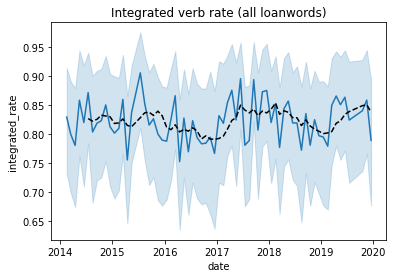

In [177]:
# # overlay original plot
word_var = 'loanword'
date_var = 'date'
light_verb_valid_integrated_rate_data = light_verb_valid_count_data.groupby([word_var, date_var]).apply(lambda x: compute_integrated_rate(x))
light_verb_valid_integrated_rate_data = light_verb_valid_integrated_rate_data.reset_index(inplace=False).rename(columns={0 : 'integrated_rate'})
light_verb_valid_integrated_rate_data.dropna(axis=0, inplace=True)
# # plot combined
light_verb_valid_integrated_rate_data = light_verb_valid_integrated_rate_data.assign(**{'is_loanword' : 1})
sns.lineplot(x=date_var, y='integrated_rate', hue='is_loanword', data=light_verb_valid_integrated_rate_data, legend=False)
plt.plot(mean_light_verb_valid_integrated_rate_data.loc[:, date_var], mean_light_verb_valid_integrated_rate_data.loc[:, 'integrated_rate_roll'], color='k', linestyle='--')
plt.title('Integrated verb rate (all loanwords)')
plt.show()

Does a regression plot looks any less bad?

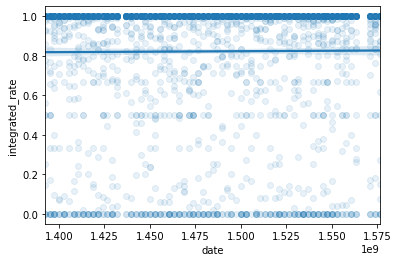

In [178]:
plot_data = light_verb_valid_integrated_rate_data.assign(**{date_var : light_verb_valid_integrated_rate_data.loc[:, date_var].apply(lambda x: x.timestamp())})
sns.regplot(x=date_var, y='integrated_rate', data=plot_data, scatter_kws={'alpha':0.1})
plt.show()

### Predict change: regression

If we add a separate effect for each loanword, will we see a consistent slope over time?

In [180]:
from importlib import reload
import model_helpers
reload(model_helpers)
from model_helpers import compute_integrated_rate, load_verb_count_data
# load full data
data_dir = '../../output/twitter_word_count_data/'
file_matcher = re.compile('LOANWORD\=[a-z]+_twitter_counts.txt')
data_files = list(filter(lambda x: file_matcher.search(x) is not None, os.listdir(data_dir)))
data_files = list(map(lambda x: os.path.join(data_dir, x), data_files))
count_data = list(map(lambda x: load_verb_count_data(x), data_files))
count_data = pd.concat(count_data, axis=0)
count_data.sort_values(['loanword', 'date'], inplace=True, ascending=True)
display(count_data.head())
loanword_var = 'loanword'
date_var = 'date_year'
integrated_rate_data = count_data.groupby([loanword_var, date_var]).apply(lambda x: compute_integrated_rate(x))
integrated_rate_data = integrated_rate_data.reset_index(inplace=False).rename(columns={0 : 'integrated_rate'})
print(integrated_rate_data)

,loanword,integrated_verb,light_verb,file_name,date,date_year
18,access,2,0,tweets-Feb-15-14-00-00,2014-02-15,2014
41,access,0,0,tweets-Mar-15-14-00-00,2014-03-15,2014
0,access,0,0,tweets-Apr-15-14-00-00,2014-04-15,2014
47,access,0,0,tweets-May-15-14-00-00,2014-05-15,2014
35,access,1,0,tweets-Jun-15-14-00-00,2014-06-15,2014


    loanword  date_year  integrated_rate
0     access       2014         1.000000
1     access       2015         1.000000
2     access       2016         0.952381
3     access       2017         1.000000
4     access       2018         1.000000
..       ...        ...              ...
709      zap       2015         0.628571
710      zap       2016         0.230769
711      zap       2017         0.384615
712      zap       2018         0.200000
713      zap       2019         0.190476

[714 rows x 3 columns]


/hg190/istewart6/loanword_adoption/scripts/models/model_helpers.py:343: RuntimeWarning: invalid value encountered in long_scalars
  return integrated_rate


In [185]:
# easy model: regression
from statsmodels.api import GLM
from statsmodels.genmod.families.family import Gaussian
dep_var = 'integrated_rate'
word_var = 'loanword'
date_var = 'date_year'
formula = f'{dep_var} ~ C({word_var}) + {date_var}'
model = GLM.from_formula(formula, data=integrated_rate_data, family=Gaussian())
model_results = model.fit()
print(model_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        integrated_rate   No. Observations:                  523
Model:                            GLM   Df Residuals:                      417
Model Family:                Gaussian   Df Model:                          105
Link Function:               identity   Scale:                        0.018292
Method:                          IRLS   Log-Likelihood:                 363.46
Date:                Sat, 06 Jun 2020   Deviance:                       7.6277
Time:                        18:40:26   Pearson chi2:                     7.63
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

OK! We get strong effects for specific words but not for time.

Same thing but with monthly data.

In [189]:
loanword_var = 'loanword'
date_var = 'date'
integrated_rate_data = count_data.groupby([loanword_var, date_var]).apply(lambda x: compute_integrated_rate(x))
integrated_rate_data = integrated_rate_data.reset_index(inplace=False).rename(columns={0 : 'integrated_rate'})
# convert date to float val
integrated_rate_data = integrated_rate_data.assign(**{
    'time_stamp' : integrated_rate_data.loc[:, 'date'].apply(lambda x: x.timestamp())
})
# drop nan vals
integrated_rate_data.dropna(axis=0, inplace=True)
display(integrated_rate_data.head())

/hg190/istewart6/loanword_adoption/scripts/models/model_helpers.py:343: RuntimeWarning: invalid value encountered in long_scalars
  return integrated_rate


,loanword,date,integrated_rate,time_stamp
0,access,2014-02-15,1.0,1.392422e+09
4,access,2014-06-15,1.0,1.402790e+09
7,access,2014-09-15,1.0,1.410739e+09
8,access,2014-10-15,1.0,1.413331e+09
9,access,2014-11-15,1.0,1.416010e+09


In [190]:
dep_var = 'integrated_rate'
word_var = 'loanword'
date_var = 'time_stamp'
formula = f'{dep_var} ~ C({word_var}) + {date_var}'
model = GLM.from_formula(formula, data=integrated_rate_data, family=Gaussian())
model_results = model.fit()
print(model_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        integrated_rate   No. Observations:                 4031
Model:                            GLM   Df Residuals:                     3925
Model Family:                Gaussian   Df Model:                          105
Link Function:               identity   Scale:                        0.030897
Method:                          IRLS   Log-Likelihood:                 1342.0
Date:                Sat, 06 Jun 2020   Deviance:                       121.27
Time:                        18:48:53   Pearson chi2:                     121.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

OK! Similarly, no effect.

Let's restrict the data to the most frequent words.

In [210]:
min_count = 100
word_var = 'loanword'
loanword_counts = count_data.groupby(word_var).apply(lambda x: x.loc[:, ['integrated_verb', 'light_verb']].sum(axis=0).sum()).sort_values(ascending=False)
print(loanword_counts.head(10))
freq_loanwords = loanword_counts[loanword_counts >= min_count].index.tolist()
print('%d/%d freq loanwords'%(len(freq_loanwords), len(loanword_counts)))
freq_count_data = count_data[count_data.loc[:, word_var].isin(freq_loanwords)]

loanword
stalk      16325
ship       16273
connect    15655
flip       13227
hack       11835
flash       7117
punch       5514
fangirl     5200
like        5110
post        4608
dtype: int64
53/119 freq loanwords


In [214]:
from sklearn.preprocessing import StandardScaler
loanword_var = 'loanword'
date_var = 'date'
integrated_rate_data = freq_count_data.groupby([loanword_var, date_var]).apply(lambda x: compute_integrated_rate(x))
integrated_rate_data = integrated_rate_data.reset_index(inplace=False).rename(columns={0 : 'integrated_rate'})
# convert date to float val
integrated_rate_data = integrated_rate_data.assign(**{
    'time_stamp' : integrated_rate_data.loc[:, 'date'].apply(lambda x: x.timestamp())
})
# Z-norm time var
if(date_var == 'date'):
    time_var = 'time_stamp'
else:
    time_var = date_var
scaler = StandardScaler()
integrated_rate_data = integrated_rate_data.assign(**{
    time_var : scaler.fit_transform(integrated_rate_data.loc[:, time_var].values.reshape(-1,1))
})
# drop nan vals
integrated_rate_data.dropna(axis=0, inplace=True)
display(integrated_rate_data.head())

/hg190/istewart6/loanword_adoption/scripts/models/model_helpers.py:343: RuntimeWarning: invalid value encountered in long_scalars
  return integrated_rate


,loanword,date,integrated_rate,time_stamp
0,audit,2014-02-15,1.0,-1.705500
1,audit,2014-03-15,1.0,-1.660612
2,audit,2014-04-15,1.0,-1.610915
5,audit,2014-07-15,1.0,-1.465028
6,audit,2014-08-15,1.0,-1.415331


In [215]:
dep_var = 'integrated_rate'
word_var = 'loanword'
date_var = 'time_stamp'
formula = f'{dep_var} ~ C({word_var}) + {date_var}'
model = GLM.from_formula(formula, data=integrated_rate_data, family=Gaussian())
model_results = model.fit()
print(model_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        integrated_rate   No. Observations:                 3328
Model:                            GLM   Df Residuals:                     3274
Model Family:                Gaussian   Df Model:                           53
Link Function:               identity   Scale:                        0.019690
Method:                          IRLS   Log-Likelihood:                 1840.6
Date:                Sat, 06 Jun 2020   Deviance:                       64.464
Time:                        19:12:43   Pearson chi2:                     64.5
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

OK! Even with the more "stable" words we still don't see significant change.

### Predict integration change: ARIMA model

Let's try to fit an autoregressive model to the data. It may be the case that the patterns of increasing and decreasing that we see can be explained by the same overall model.

In [ ]:
# choose parameters with the lowest AIC

### Predict integration change: more dense data
Let's try using the original loanword data (2017-2019) which is more dense and therefore might have more accurate counts.

In [249]:
import sys
if('..' not in sys.path):
    sys.path.append('..')
from data_processing.data_helpers import clean_date_values
import pandas as pd
loanword_full_data = pd.read_csv('../../data/mined_tweets/loanword_verbs_post_social_data.tsv', sep='\t', usecols=['created_at', 'loanword', 'loanword_type'])
loanword_full_data = clean_date_values(loanword_full_data)
display(loanword_full_data.head())

,loanword,loanword_type,created_at,clean_date
0,audit,integrated_loanword,2017-08-01T22:06:25+00:00,2017-08-01 22:06:25+00:00
1,ban,integrated_loanword,2017-07-04T23:08:51+00:00,2017-07-04 23:08:51+00:00
2,ban,integrated_loanword,2017-08-06T00:58:05+00:00,2017-08-06 00:58:05+00:00
3,flip,integrated_loanword,2018-01-07T02:58:26+00:00,2018-01-07 02:58:26+00:00
4,ban,integrated_loanword,2017-08-20T14:29:57+00:00,2017-08-20 14:29:57+00:00


First: compute counts per word per date.

In [277]:
# per-month 
from datetime import datetime
def round_to_date(x, date_round_type='month'):
    date_clean = datetime.utcfromtimestamp(x.tolist()/1e9)
    default_day = 1
    if(date_round_type == 'month'):
        round_date = datetime(day=default_day, month=date_clean.month, year=date_clean.year)
    return round_date
month_var = 'date_month'
round_dates = []
for clean_date_i in loanword_full_data.loc[:, 'clean_date'].values:
    round_date_i = round_to_date(clean_date_i, date_round_type='month')
    round_dates.append(round_date_i)
loanword_full_data = loanword_full_data.assign(**{
    month_var : round_dates
})
display(loanword_full_data.head())

,loanword,loanword_type,created_at,clean_date,date_month
0,audit,integrated,2017-08-01T22:06:25+00:00,2017-08-01 22:06:25+00:00,2017-08-01
1,ban,integrated,2017-07-04T23:08:51+00:00,2017-07-04 23:08:51+00:00,2017-07-01
2,ban,integrated,2017-08-06T00:58:05+00:00,2017-08-06 00:58:05+00:00,2017-08-01
3,flip,integrated,2018-01-07T02:58:26+00:00,2018-01-07 02:58:26+00:00,2018-01-01
4,ban,integrated,2017-08-20T14:29:57+00:00,2017-08-20 14:29:57+00:00,2017-08-01


In [278]:
# compute counts
word_var = 'loanword'
word_type_var = 'loanword_type'
round_date_var = 'date_month'
loanword_full_data_counts = loanword_full_data.groupby([word_var, word_type_var, round_date_var]).apply(lambda x: x.shape[0]).reset_index().rename(columns={0:'count'})
loanword_full_data_counts = loanword_full_data_counts.assign(**{
    word_type_var : loanword_full_data_counts.loc[:, word_type_var].apply(lambda x: x.replace('_loanword', ''))
})
# flatten data, same as before
# loanword | integrated verb count | light verb count | date
count_var = 'count'
loanword_full_data_counts_flat = []
for (word_i, date_i), data_i in loanword_full_data_counts.groupby([word_var, round_date_var]):
    word_type_counts_i = data_i.groupby(word_type_var).apply(lambda x: x.loc[:, count_var].sum())
    flat_data_i = word_type_counts_i.append(pd.Series([word_i, date_i], index=[word_var, round_date_var]))
    loanword_full_data_counts_flat.append(flat_data_i)
loanword_full_data_counts_flat = pd.concat(loanword_full_data_counts_flat, axis=1).transpose()
loanword_full_data_counts_flat.fillna(0., inplace=True)
loanword_full_data_counts_flat.rename(columns={'integrated':'integrated_verb'}, inplace=True)
display(loanword_full_data_counts_flat.head())

,light_verb,loanword,date_month,integrated_verb
0,3.0,DM,2017-06-01,0.0
1,136.0,DM,2017-07-01,0.0
2,103.0,DM,2017-08-01,0.0
3,3.0,DM,2017-09-01,0.0
4,101.0,DM,2017-10-01,0.0


In [281]:
# compute integrated rate same as before
import sys
if('..' not in sys.path):
    sys.path.append('..')
from importlib import reload
import data_processing.data_helpers
reload(data_processing.data_helpers)
from data_processing.data_helpers import compute_integrated_rate
word_var = 'loanword'
round_date_var = 'date_month'
loanword_full_data_integrated_rate = loanword_full_data_counts_flat.groupby([word_var, round_date_var]).apply(lambda x: compute_integrated_rate(x)).reset_index().rename(columns={0:'integrated_rate'})
display(loanword_full_data_integrated_rate.head())

,loanword,date_month,integrated_rate
0,DM,2017-06-01,0.0
1,DM,2017-07-01,0.0
2,DM,2017-08-01,0.0
3,DM,2017-09-01,0.0
4,DM,2017-10-01,0.0


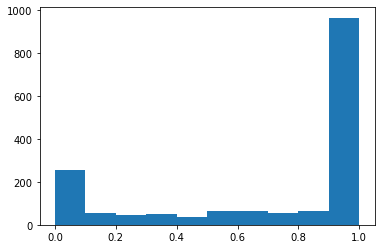

In [282]:
# plot distribution of integration
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(loanword_full_data_integrated_rate.loc[:, 'integrated_rate'])
plt.show()

As expected: most verbs tend to be fully integrated or non-integrated.

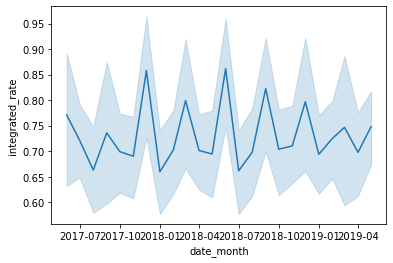

In [285]:
# change over time
import seaborn as sns
month_date_var = 'date_month'
integrated_rate_var = 'integrated_rate'
dummy_var = 'is_loanword'
loanword_full_data_integrated_rate = loanword_full_data_integrated_rate.assign(**{
    dummy_var : 1
})
sns.lineplot(x=month_date_var, y=integrated_rate_var, hue=dummy_var, data=loanword_full_data_integrated_rate, legend=False)
plt.show()

We see a pretty steady rate of integration, which may be due to data sparsity.

Let's redo this with 3-month aggregations.

In [307]:
from datetime import datetime, timedelta
import calendar
import numpy as np
def add_months(sourcedate, months):
    month = sourcedate.month - 1 + months
    year = sourcedate.year + month // 12
    month = month % 12 + 1
    day = min(sourcedate.day, calendar.monthrange(year,month)[1])
    new_date = datetime(year=year, month=month, day=day)
    return new_date
def bin_by_month_period(date_val, month_bin_window=3):
    """
    Bin date into nearest X-month period.
    We assume that month window divides the year evenly:
    X={2, 3, 4, 6}
    """
    months_per_year = 12
    date_year = date_val.year
    start_date = datetime(year=date_year, day=1, month=1)
    month_bin_count = int(months_per_year / month_bin_window)
    month_bins = list(map(lambda x: add_months(start_date, month_bin_window*x), range(month_bin_count)))
    month_bin_timestamps = list(map(lambda x: x.timestamp(), month_bins))
    date_val_timestamp = date_val.timestamp()
    date_val_bin = np.digitize([date_val_timestamp], month_bin_timestamps)[0]
    date_val_month_bin = month_bins[date_val_bin-1]
    return date_val_month_bin
# c = bin_by_month_period(a, month_bin_window=3)
# print(a)
# print(c)
month_bin_window = 3
date_window_var = 'date_window'
loanword_full_data = loanword_full_data.assign(**{
    date_window_var : loanword_full_data.loc[:, 'clean_date'].apply(lambda x: bin_by_month_period(x, month_bin_window=month_bin_window))
})

,light_verb,loanword,date_window,integrated_verb
0,3.0,DM,2017-04-01,0.0
1,242.0,DM,2017-07-01,0.0
2,195.0,DM,2017-10-01,0.0
3,215.0,DM,2018-01-01,0.0
4,226.0,DM,2018-04-01,0.0


,loanword,date_window,integrated_rate
0,DM,2017-04-01,0.0
1,DM,2017-07-01,0.0
2,DM,2017-10-01,0.0
3,DM,2018-01-01,0.0
4,DM,2018-04-01,0.0


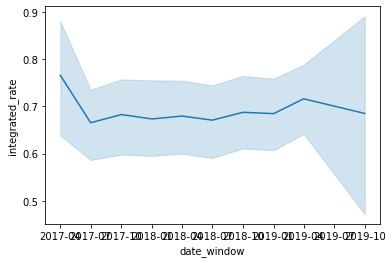

In [311]:
# compute integrated rate same as before
count_var = 'count'
word_type_var = 'loanword_type'
date_window_var = 'date_window'
loanword_full_data_counts = loanword_full_data.groupby([word_var, word_type_var, date_window_var]).apply(lambda x: x.shape[0]).reset_index().rename(columns={0:'count'})
loanword_full_data_counts = loanword_full_data_counts.assign(**{
    word_type_var : loanword_full_data_counts.loc[:, word_type_var].apply(lambda x: x.replace('_loanword', ''))
})
word_type_var : loanword_full_data_counts.loc[:, word_type_var].apply(lambda x: x.replace('_loanword', ''))
loanword_full_data_counts_flat = []
for (word_i, date_i), data_i in loanword_full_data_counts.groupby([word_var, date_window_var]):
    word_type_counts_i = data_i.groupby(word_type_var).apply(lambda x: x.loc[:, count_var].sum())
    flat_data_i = word_type_counts_i.append(pd.Series([word_i, date_i], index=[word_var, date_window_var]))
    loanword_full_data_counts_flat.append(flat_data_i)
loanword_full_data_counts_flat = pd.concat(loanword_full_data_counts_flat, axis=1).transpose()
loanword_full_data_counts_flat.fillna(0., inplace=True)
loanword_full_data_counts_flat.rename(columns={'integrated':'integrated_verb'}, inplace=True)
display(loanword_full_data_counts_flat.head())
word_var = 'loanword'
loanword_full_data_integrated_rate = loanword_full_data_counts_flat.groupby([word_var, date_window_var]).apply(lambda x: compute_integrated_rate(x)).reset_index().rename(columns={0:'integrated_rate'})
display(loanword_full_data_integrated_rate.head())
# change over time
import seaborn as sns
integrated_rate_var = 'integrated_rate'
dummy_var = 'is_loanword'
loanword_full_data_integrated_rate = loanword_full_data_integrated_rate.assign(**{
    dummy_var : 1
})
sns.lineplot(x=date_window_var, y=integrated_rate_var, hue=dummy_var, data=loanword_full_data_integrated_rate, legend=False)
plt.show()

OK! Basically a flat curve.

What if we use fixed effects to control for possible population effects?

In [317]:
from sklearn.preprocessing import StandardScaler
# convert date variable to continuous
date_var = 'date_window'
loanword_full_data_integrated_rate = loanword_full_data_integrated_rate.assign(**{
    f'{date_var}_timestamp' : loanword_full_data_integrated_rate.loc[:, date_var].apply(lambda x: x.timestamp())
})
# Z-norm
scaler = StandardScaler()
loanword_full_data_integrated_rate = loanword_full_data_integrated_rate.assign(**{
    f'{date_var}_timestamp' : scaler.fit_transform(loanword_full_data_integrated_rate.loc[:, f'{date_var}_timestamp'].values.reshape(-1,1))
})

In [318]:
from statsmodels.api import GLM
from statsmodels.genmod.families.family import Gaussian
dep_var = 'integrated_rate'
word_var = 'loanword'
date_var = 'date_window_timestamp'
formula = f'{dep_var} ~ C({word_var}) + {date_var}'
model = GLM.from_formula(formula, data=loanword_full_data_integrated_rate, family=Gaussian())
model_results = model.fit()
print(model_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        integrated_rate   No. Observations:                  812
Model:                            GLM   Df Residuals:                      700
Model Family:                Gaussian   Df Model:                          111
Link Function:               identity   Scale:                        0.017683
Method:                          IRLS   Log-Likelihood:                 546.36
Date:                Sun, 07 Jun 2020   Deviance:                       12.378
Time:                        22:33:57   Pearson chi2:                     12.4
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

OK! We see a weak positive trend. Maybe this would be amplified if we restricted to the most frequent words.

In [328]:
word_var = 'loanword'
loanword_counts = loanword_full_data.loc[:, word_var].value_counts()
min_count = 100
freq_words = loanword_counts[loanword_counts >= min_count].index.tolist()
print('%d/%d freq words'%(len(freq_words), len(loanword_counts)))

59/111 freq words


In [329]:
word_var = 'loanword'
date_var = 'date_window'
freq_loanword_full_data_integrated_rate = loanword_full_data_integrated_rate[loanword_full_data_integrated_rate.loc[:, word_var].isin(freq_words)]
# Z-norm
scaler = StandardScaler()
freq_loanword_full_data_integrated_rate = freq_loanword_full_data_integrated_rate.assign(**{
    f'{date_var}_timestamp' : scaler.fit_transform(freq_loanword_full_data_integrated_rate.loc[:, f'{date_var}_timestamp'].values.reshape(-1,1))
})

In [330]:
dep_var = 'integrated_rate'
word_var = 'loanword'
date_var = 'date_window_timestamp'
formula = f'{dep_var} ~ C({word_var}) + {date_var}'
model = GLM.from_formula(formula, data=freq_loanword_full_data_integrated_rate, family=Gaussian())
model_results = model.fit()
print(model_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        integrated_rate   No. Observations:                  523
Model:                            GLM   Df Residuals:                      463
Model Family:                Gaussian   Df Model:                           59
Link Function:               identity   Scale:                       0.0098356
Method:                          IRLS   Log-Likelihood:                 498.35
Date:                Sun, 07 Jun 2020   Deviance:                       4.5539
Time:                        22:39:33   Pearson chi2:                     4.55
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -3

## Relative time
Let's shift from looking at absolute time to relative time.

### Compare change before/after frequency change
We have previously assumed that all loanwords are changing at the same rate, but this may not hold.
For instance, if `google` is a more recently adopted loanword than `tweet` based on a relative lower frequency, it may not be integrated.

Let's look at words that have (1) sufficiently high overall frequency and (2) have a significant frequency change.
If these words also show a significant change in integration likelihood, then we can confirm a time effect.

In [4]:
import pandas as pd
import re
import os
from importlib import reload
import sys
if('..' not in sys.path):
    sys.path.append('..')
import data_processing.data_helpers
reload(data_processing.data_helpers)
from data_processing.data_helpers import load_verb_count_data, bin_by_month_period
import numpy as np
# load data
data_dir = '../../output/twitter_word_count_data/'
file_matcher = re.compile('LOANWORD\=[a-z]+_twitter_counts.txt')
data_files = list(filter(lambda x: file_matcher.search(x) is not None, os.listdir(data_dir)))
data_files = list(map(lambda x: os.path.join(data_dir, x), data_files))
count_data = list(map(lambda x: load_verb_count_data(x), data_files))
count_data = pd.concat(count_data, axis=0)
count_data.sort_values(['loanword', 'date'], inplace=True, ascending=True)
# get total counts per word
count_data = count_data.assign(**{
    'total_verb_count' : count_data.loc[:, ['integrated_verb', 'light_verb']].sum(axis=1)
})
## normalize by total counts at each date
total_post_count_data = pd.read_csv('../../output/twitter_word_count_data/LANG=es_twitter_total_counts.txt', sep=',')
total_post_count_data.columns = ['post_count', 'file_name']
count_data = pd.merge(count_data, total_post_count_data, on='file_name')
count_data = count_data.assign(**{
    'norm_total_verb_count' : count_data.loc[:, 'total_verb_count'] / count_data.loc[:, 'post_count']
})
## compute integrated rate: per month
count_data = count_data.assign(**{
    'integrated_verb_rate' : count_data.loc[:, 'integrated_verb'] / count_data.loc[:, 'total_verb_count']
})
display(count_data.head())

## compute integrated rate: per 6-month window
month_window = 6
month_window_date_var = 'date_%d_window'%(month_window)
count_data = count_data.assign(**{
    month_window_date_var : count_data.loc[:, 'date'].apply(lambda x: bin_by_month_period(x, month_bin_window=month_window))
})
window_count_data = []
count_vars = ['integrated_verb', 'light_verb', 'total_verb_count']
word_var = 'loanword'
for (date_i, word_i), data_i in count_data.groupby([month_window_date_var, word_var]):
    count_var_vals_i = data_i.loc[:, count_vars].sum(axis=0)
    post_count_i = data_i.loc[:, 'post_count'].iloc[0]
    norm_verb_count_i = count_var_vals_i.loc['total_verb_count'] / post_count_i
    integrated_verb_rate_i = count_var_vals_i.loc['integrated_verb'] / count_var_vals_i.loc['total_verb_count']
    window_count_data_i = count_var_vals_i.values.tolist() + [post_count_i, norm_verb_count_i, integrated_verb_rate_i, word_i, date_i]
    idx_i = count_vars + ['post_count', 'norm_total_verb_count', 'integrated_verb_rate', 'loanword', month_window_date_var]
    window_count_data_i = pd.Series(window_count_data_i, index=idx_i)
    window_count_data.append(window_count_data_i)
window_count_data = pd.concat(window_count_data, axis=1).transpose()
display(window_count_data.head())

,loanword,integrated_verb,light_verb,file_name,date,date_year,total_verb_count,post_count,norm_total_verb_count,integrated_verb_rate
0,access,2,0,tweets-Feb-15-14-00-00,2014-02-15,2014,2,621051,0.000003,1.0
1,aim,0,0,tweets-Feb-15-14-00-00,2014-02-15,2014,0,621051,0.000000,NaN
2,alert,0,0,tweets-Feb-15-14-00-00,2014-02-15,2014,0,621051,0.000000,NaN
3,audit,3,0,tweets-Feb-15-14-00-00,2014-02-15,2014,3,621051,0.000005,1.0
4,ban,12,0,tweets-Feb-15-14-00-00,2014-02-15,2014,12,621051,0.000019,1.0


/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in long_scalars


,integrated_verb,light_verb,total_verb_count,post_count,norm_total_verb_count,integrated_verb_rate,loanword,date_6_window
0,3,0,3,621051,4.83052e-06,1,access,2014-01-01
1,0,0,0,621051,0,NaN,aim,2014-01-01
2,0,0,0,621051,0,NaN,alert,2014-01-01
3,7,0,7,621051,1.12712e-05,1,audit,2014-01-01
4,54,0,54,621051,8.69494e-05,1,ban,2014-01-01


Identify words with relatively high frequency.

In [5]:
min_count = 50
word_var = 'loanword'
word_count_var = 'total_verb_count'
word_counts = count_data.groupby(word_var).apply(lambda x: x.loc[:, word_count_var].sum())
freq_word_counts = word_counts[word_counts >= min_count]
freq_count_data = count_data[count_data.loc[:, word_var].isin(freq_word_counts.index)]

In [ ]:
# plot all word frequencies
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from math import ceil, floor
N = freq_count_data.loc[:, word_var].nunique()
cols = 3
rows = int(ceil(N / cols))
month_date_var = 'date'
norm_count_var = 'norm_total_verb_count'
f, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*3))
for i, (word_i, data_i) in enumerate(freq_count_data.groupby(word_var)):
    X = data_i.loc[:, month_date_var]
    Y = data_i.loc[:, norm_count_var]
    ax = axs[int(floor(i / cols)), i % cols]
    ax.scatter(X, Y)
    ax.set_title(word_i)
plt.tight_layout()
plt.show()

Now let's test the difference before and after the midpoint.

In [386]:
# easy method: define midpoint as before/after
from scipy.stats import mannwhitneyu
import numpy as np
# split data into two time periods, compare frequency before/after
# limit to words that grow in frequency
month_date_var = 'date'
p_val_upper = 0.05 / freq_count_data.loc[:, word_var].nunique()
growth_words = []
for word_i, data_i in freq_count_data.groupby(word_var):
    min_date_i = data_i.loc[:, month_date_var].min()
    max_date_i = data_i.loc[:, month_date_var].max()
    split_point_i = min_date_i + (max_date_i - min_date_i) / 2.
    pre_split_counts_i = data_i[data_i.loc[:, month_date_var] <= split_point_i].loc[:, norm_count_var]
    post_split_counts_i = data_i[data_i.loc[:, month_date_var] >= split_point_i].loc[:, norm_count_var]
    count_diff = post_split_counts_i.mean() - pre_split_counts_i.mean()
    test_stat, p_val = mannwhitneyu(pre_split_counts_i, post_split_counts_i)
    if(p_val < p_val_upper):
#         print('word <%s> has significant change %.3E'%(word_i, count_diff))
        if(count_diff > 0.):
            growth_words.append(word_i)
print(len(growth_words))
# compare rate of integration before/after
integrated_rate_var = 'integrated_verb_rate'
pre_split_integrated_rates = []
post_split_integrated_rates = []
growth_count_data = freq_count_data[freq_count_data.loc[:, word_var].isin(growth_words)]
for word_i, data_i in growth_count_data.groupby(word_var):
    min_date_i = data_i.loc[:, month_date_var].min()
    max_date_i = data_i.loc[:, month_date_var].max()
    split_point_i = min_date_i + (max_date_i - min_date_i) / 2.
    pre_split_integrated_rate_i = data_i[data_i.loc[:, month_date_var] <= split_point_i].loc[:, integrated_rate_var].dropna(inplace=False)
    post_split_integrated_rate_i = data_i[data_i.loc[:, month_date_var] >= split_point_i].loc[:, integrated_rate_var].dropna(inplace=False)
    mean_pre_split_integrated_rate_i = pre_split_integrated_rate_i.mean()
    mean_post_split_integrated_rate_i = post_split_integrated_rate_i.mean()
    integrated_rate_diff_i = mean_post_split_integrated_rate_i - mean_pre_split_integrated_rate_i
    if(integrated_rate_diff_i != 0.):
        test_stat, p_val = mannwhitneyu(pre_split_integrated_rate_i, post_split_integrated_rate_i)
        print('word <%s> has integrated rate change %.3E (test stat=%.3f, p=%.3E)'%(word_i, integrated_rate_diff_i, test_stat, p_val))
    pre_split_integrated_rates.append(mean_pre_split_integrated_rate_i)
    post_split_integrated_rates.append(mean_post_split_integrated_rate_i)
# compare overall distribution of pre/post split
test_stat, p_val = mannwhitneyu(pre_split_integrated_rates, post_split_integrated_rates)
mean_integrated_rate_diff = np.mean(post_split_integrated_rates) - np.mean(pre_split_integrated_rates)
print('mean integrated rate diff = %.3f (test stat = %.3f, p = %.3E)'%(mean_integrated_rate_diff, test_stat, p_val))

19
word <block> has integrated rate change 2.359E-01 (test stat=257.500, p=5.827E-05)
word <boycott> has integrated rate change 3.488E-02 (test stat=556.000, p=4.753E-01)
word <cast> has integrated rate change 4.395E-01 (test stat=178.500, p=9.728E-06)
word <check> has integrated rate change 2.698E-03 (test stat=534.000, p=4.255E-01)
word <fangirl> has integrated rate change 1.505E-01 (test stat=201.000, p=3.260E-06)
word <film> has integrated rate change -6.684E-04 (test stat=544.500, p=1.697E-01)
word <flip> has integrated rate change 6.489E-05 (test stat=544.000, p=1.623E-01)
word <format> has integrated rate change -1.269E-02 (test stat=494.000, p=1.151E-01)
word <google> has integrated rate change 7.081E-02 (test stat=391.000, p=6.595E-03)
word <like> has integrated rate change -2.608E-03 (test stat=559.500, p=4.950E-01)
word <pitch> has integrated rate change -3.299E-03 (test stat=511.500, p=4.319E-02)
word <post> has integrated rate change 9.481E-03 (test stat=534.000, p=3.655E-

Not great! Overall we see a weak increase in integration among growth words. BUT, among growth words, the only significant changes in word integration are positive (`block`, `cast`, `fangirl`, `google`).

In [558]:
# better method: find max-frequency period and compare before/after
# smooth all time series
word_var = 'loanword'
norm_count_var = 'norm_total_verb_count'
integrated_rate_var = 'integrated_verb_rate'
month_date_var = 'date'
smooth_count_data = freq_count_data.loc[:, [word_var, norm_count_var, integrated_rate_var, month_date_var]]
window_size = 6
smooth_count_var = 'smooth_norm_total_verb_count'
smooth_count_data = []
for word_i, data_i in freq_count_data.groupby(word_var):
    data_i.sort_values(month_date_var, inplace=True, ascending=True)
    data_i = data_i.assign(**{
        smooth_count_var : data_i.loc[:, norm_count_var].rolling(window_size).sum()
    })
    data_i = data_i.loc[:, [word_var, norm_count_var, integrated_rate_var, month_date_var, smooth_count_var]]
    # drop nans
    data_i.dropna(axis=0, subset=[smooth_count_var], inplace=True)
    smooth_count_data.append(data_i)
smooth_count_data = pd.concat(smooth_count_data, axis=0)
# find max period per word
word_peak_dates = smooth_count_data.groupby(word_var).apply(lambda x: x.iloc[np.argmax(x.loc[:, smooth_count_var]), :].loc[month_date_var])
print(word_peak_dates)

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


loanword
access   2016-06-15
audit    2019-07-15
ban      2019-01-15
block    2019-07-15
box      2017-12-15
            ...    
troll    2014-08-15
tweet    2019-04-15
twerk    2019-02-15
vape     2017-07-15
zap      2016-10-15
Length: 63, dtype: datetime64[ns]


Sanity check: do the time series look reasonably smooth?

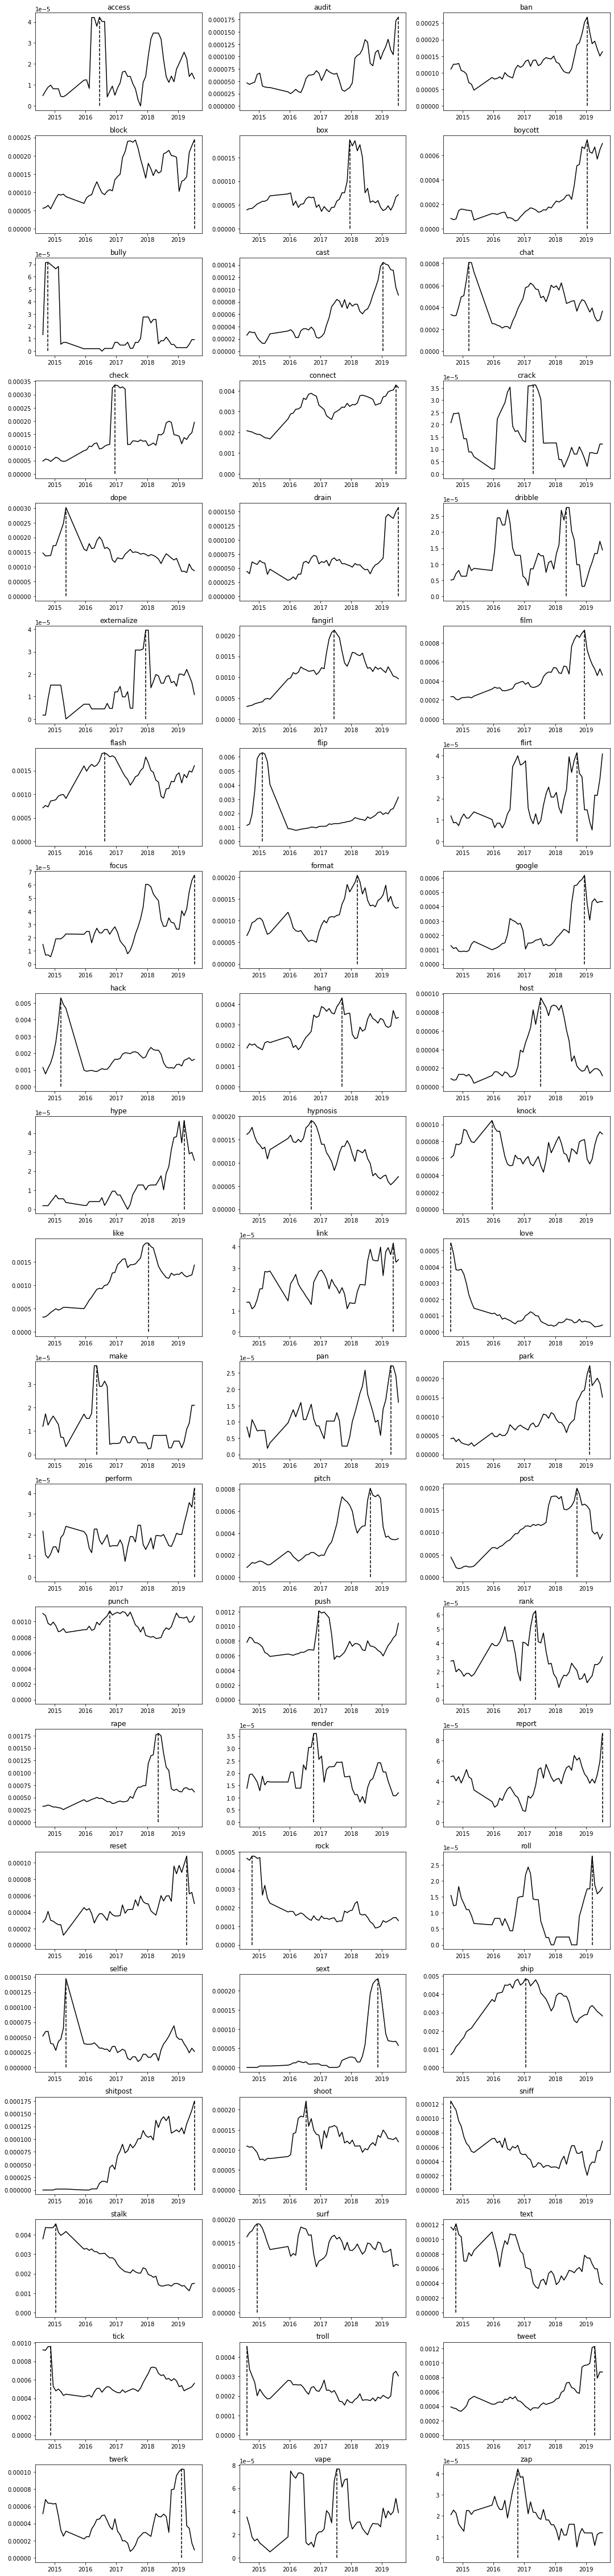

In [559]:
from math import ceil, floor
word_var = 'loanword'
smooth_count_var = 'smooth_norm_total_verb_count'
N = smooth_count_data.loc[:, word_var].nunique()
cols = 3
rows = int(ceil(N / cols))
f, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*3))
for i, (word_i, data_i) in enumerate(smooth_count_data.groupby(word_var)):
    split_date_i = word_peak_dates.loc[word_i]
    ax = axs[int(floor(i / cols)), i % cols]
    # plot counts
    ax.plot(data_i.loc[:, date_var], data_i.loc[:, smooth_count_var], color='k')
    # plot peak point
    y_max = data_i.loc[:, freq_var].max()
    y_min = 0.
    ax.vlines(split_date_i, y_min, y_max, linestyle='--', color='k')
    # add labels
    ax.set_title(word_i)
plt.tight_layout()
plt.show()

OK! We should probably use the split point for words without a clear growth trajectory; for words with clear growth/decline we can just use the halfway point.

word <connect> has mean integrated rate diff 0.000E+00 (test stat = 130.000, p = 2.113E-04)
word <drain> has mean integrated rate diff 0.000E+00 (test stat = 99.500, p = 4.246E-05)
word <externalize> has mean integrated rate diff 0.000E+00 (test stat = 216.000, p = 1.139E-05)
word <fangirl> has mean integrated rate diff 1.397E-01 (test stat = 239.500, p = 1.482E-05)


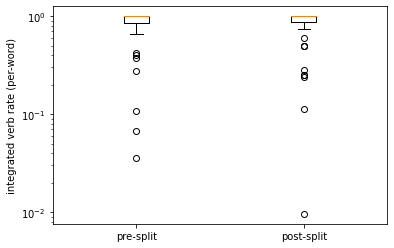

post/pre split has mean integrated verb diff -3.981E-03 (test stat = 512.000, p = 7.555E-01)
filtered post/pre split has mean integrated verb diff -5.453E-03 (test stat = 512.000, p = 7.555E-01)


In [464]:
# compare integration before/after: per-word
from scipy.stats import mannwhitneyu
p_val_upper = 0.05 / freq_count_data.loc[:, word_var].nunique()
for word_i, data_i in freq_count_data.groupby(word_var):
    word_peak_date_i = word_peak_dates.loc[word_i]
    pre_split_integrated_rate_i = data_i[data_i.loc[:, month_date_var] < word_peak_date_i].loc[:, integrated_rate_var]
    post_split_integrated_rate_i = data_i[data_i.loc[:, month_date_var] > word_peak_date_i].loc[:, integrated_rate_var]
    mean_diff_i = post_split_integrated_rate_i.mean() - pre_split_integrated_rate_i.mean()
    test_stat, p_val = mannwhitneyu(pre_split_integrated_rate_i, post_split_integrated_rate_i)
    if(p_val < p_val_upper):
        print('word <%s> has mean integrated rate diff %.3E (test stat = %.3f, p = %.3E)'%(word_i, mean_diff_i, test_stat, p_val))
# compare integration before/after: aggregate integrated verb rate with paired test
from scipy.stats import wilcoxon
freq_words = freq_count_data.loc[:, word_var].unique()
integrated_count_var = 'integrated_verb'
verb_count_var = 'total_verb_count'
pre_split_integrated_rates = []
post_split_integrated_rates = []
valid_integrated_rate_words = []
for word_i, data_i in freq_count_data.groupby(word_var):
    word_peak_date_i = word_peak_dates.loc[word_i]
    pre_split_data_i = data_i[data_i.loc[:, month_date_var] < word_peak_date_i]
    post_split_data_i = data_i[data_i.loc[:, month_date_var] > word_peak_date_i]
    pre_split_integrated_rate_i = pre_split_data_i.loc[:, integrated_count_var].sum() / pre_split_data_i.loc[:, verb_count_var].sum()
    post_split_integrated_rate_i = post_split_data_i.loc[:, integrated_count_var].sum() / post_split_data_i.loc[:, verb_count_var].sum()
    # filter pairs with at least one nan (invalid comparison)
    if(not(np.isnan(pre_split_integrated_rate_i) or np.isnan(post_split_integrated_rate_i))):
        pre_split_integrated_rates.append(pre_split_integrated_rate_i)
        post_split_integrated_rates.append(post_split_integrated_rate_i)
        valid_integrated_rate_words.append(word_i)
pre_split_integrated_rates = pd.Series(pre_split_integrated_rates, index=valid_integrated_rate_words)
post_split_integrated_rates = pd.Series(post_split_integrated_rates, index=valid_integrated_rate_words)
# plot distributions.
plt.boxplot([pre_split_integrated_rates, post_split_integrated_rates])
plt.xticks(np.arange(2)+1, ['pre-split', 'post-split'])
plt.ylabel('integrated verb rate (per-word)')
plt.yscale('log')
plt.show()
# paired test
integrated_rate_median_diff = np.mean(post_split_integrated_rates - pre_split_integrated_rates)
test_stat, p_val = wilcoxon(pre_split_integrated_rates, post_split_integrated_rates)
print('post/pre split has mean integrated verb diff %.3E (test stat = %.3f, p = %.3E)'%(integrated_rate_median_diff, test_stat, p_val))
# paired but with all verbs with integration < 100%
filter_integrated_rate_idx = np.where((pre_split_integrated_rates < 1.) | (post_split_integrated_rates < 1.))[0]
filter_pre_split_integrated_rates = pre_split_integrated_rates[filter_integrated_rate_idx]
filter_post_split_integrated_rates = post_split_integrated_rates[filter_integrated_rate_idx]
integrated_rate_median_diff = np.mean(filter_post_split_integrated_rates - filter_pre_split_integrated_rates)
test_stat, p_val = wilcoxon(filter_pre_split_integrated_rates, filter_post_split_integrated_rates)
print('filtered post/pre split has mean integrated verb diff %.3E (test stat = %.3f, p = %.3E)'%(integrated_rate_median_diff, test_stat, p_val))

Too bad! Let's try the same thing but restricted to words that show significant growth.

In [466]:
from scipy.stats import spearmanr, pearsonr
growth_words = []
word_var = 'loanword'
date_var = 'date'
smooth_count_var = 'smooth_norm_total_verb_count'
word_count = smooth_count_data.loc[:, word_var].nunique()
p_val_upper = 0.05 / word_count
for word_i, data_i in smooth_count_data.groupby(word_var):
    date_timestamp_i = data_i.loc[:, date_var].apply(lambda x: x.timestamp())
    correl, p_val = spearmanr(date_timestamp_i, data_i.loc[:, smooth_count_var])
    if(correl > 0. and p_val < p_val_upper):
        print('word <%s> has growth %.3f (p = %.3E)'%(word_i, correl, p_val))
        growth_words.append(word_i)
print('%d growth words'%(len(growth_words)))

word <audit> has growth 0.736 (p = 2.372E-10)
word <ban> has growth 0.727 (p = 4.941E-10)
word <block> has growth 0.758 (p = 3.129E-11)
word <boycott> has growth 0.843 (p = 1.358E-15)
word <cast> has growth 0.881 (p = 1.661E-18)
word <check> has growth 0.709 (p = 2.044E-09)
word <connect> has growth 0.758 (p = 3.129E-11)
word <externalize> has growth 0.647 (p = 1.244E-07)
word <fangirl> has growth 0.508 (p = 8.887E-05)
word <film> has growth 0.910 (p = 1.627E-21)
word <flirt> has growth 0.491 (p = 1.658E-04)
word <focus> has growth 0.772 (p = 8.403E-12)
word <format> has growth 0.724 (p = 6.245E-10)
word <google> has growth 0.791 (p = 1.109E-12)
word <hang> has growth 0.584 (p = 3.482E-06)
word <host> has growth 0.519 (p = 5.753E-05)
word <hype> has growth 0.868 (p = 2.031E-17)
word <like> has growth 0.646 (p = 1.298E-07)
word <link> has growth 0.542 (p = 2.311E-05)
word <pan> has growth 0.519 (p = 5.739E-05)
word <park> has growth 0.918 (p = 1.393E-22)
word <pitch> has growth 0.819 (p

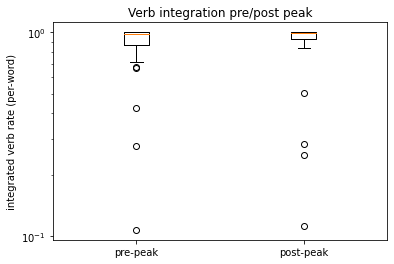

filtered post/pre split has mean integrated verb diff 1.366E-02 (test stat = 87.000, p = 3.219E-01)
word <audit> has mean integrated rate diff 0.000E+00 (test stat = nan, p = NAN)
word <ban> has mean integrated rate diff 0.000E+00 (test stat = nan, p = NAN)
word <block> has mean integrated rate diff 5.978E-03 (test stat = -0.239, p = 4.055E-01)
word <boycott> has mean integrated rate diff 3.284E-02 (test stat = -2.977, p = 1.457E-03)
SIGNIFICANT: word <cast> has mean integrated rate diff 3.016E-01 (test stat = -8.453, p = 0.000E+00)
word <check> has mean integrated rate diff -1.287E-03 (test stat = 0.110, p = 4.560E-01)
word <connect> has mean integrated rate diff 0.000E+00 (test stat = nan, p = NAN)
word <externalize> has mean integrated rate diff 0.000E+00 (test stat = nan, p = NAN)
SIGNIFICANT: word <fangirl> has mean integrated rate diff 1.490E-01 (test stat = -14.334, p = 0.000E+00)
word <film> has mean integrated rate diff -3.356E-03 (test stat = 2.423, p = 7.705E-03)
word <flirt

/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [560]:
from scipy.stats import wilcoxon, ttest_rel, norm
def binomial_test(p_1, p_2, n_1, n_2):
    p_pool = (n_1*p_1 + n_2*p_2)/(n_1 + n_2)
    z_norm = (p_1 - p_2) / (p_pool*(1-p_pool)*(1/n_1 + 1/n_2))**.5
    p_val = 1-norm.cdf(abs(z_norm))
    return z_norm, p_val
# filter only growth words
growth_pre_split_integrated_rates = pre_split_integrated_rates.loc[growth_words]
growth_post_split_integrated_rates = post_split_integrated_rates.loc[growth_words]
plt.boxplot([growth_pre_split_integrated_rates, growth_post_split_integrated_rates])
plt.xticks(np.arange(2)+1, ['pre-peak', 'post-peak'])
plt.ylabel('integrated verb rate (per-word)')
plt.title('Verb integration pre/post peak')
plt.yscale('log')
plt.show()
# overall difference
integrated_rate_median_diff = np.mean(growth_post_split_integrated_rates - growth_pre_split_integrated_rates)
test_stat, p_val = wilcoxon(growth_pre_split_integrated_rates, growth_post_split_integrated_rates)
# test_stat, p_val = ttest_rel(growth_pre_split_integrated_rates, growth_post_split_integrated_rates)
print('filtered post/pre split has mean integrated verb diff %.3E (test stat = %.3f, p = %.3E)'%(integrated_rate_median_diff, test_stat, p_val))
# how many words have significant differences?
integrated_count_var = 'integrated_verb'
verb_count_var = 'total_verb_count'
growth_freq_count_data = freq_count_data[freq_count_data.loc[:, word_var].isin(growth_words)]
p_val_upper = 0.05 / freq_count_data.loc[:, word_var].nunique()
for word_i, data_i in growth_freq_count_data.groupby(word_var):
    word_peak_date_i = word_peak_dates.loc[word_i]
    pre_split_data_i = data_i[data_i.loc[:, month_date_var] < word_peak_date_i]
    post_split_data_i = data_i[data_i.loc[:, month_date_var] > word_peak_date_i]
    # per-word rate
#     pre_split_integrated_rate_i = pre_split_data_i.loc[:, integrated_rate_var]
#     post_split_integrated_rate_i = post_split_data_i.loc[:, integrated_rate_var]
    # total rate
    pre_split_integrated_rate_i = pre_split_data_i.loc[:, integrated_count_var].sum() / pre_split_data_i.loc[:, verb_count_var].sum()
    post_split_integrated_rate_i = post_split_data_i.loc[:, integrated_count_var].sum() / post_split_data_i.loc[:, verb_count_var].sum()
    mean_diff_i = post_split_integrated_rate_i - pre_split_integrated_rate_i
    pre_split_count_i = pre_split_data_i.loc[:, verb_count_var].sum()
    post_split_count_i = pre_split_data_i.loc[:, verb_count_var].sum()
    # total rate test
    test_stat, p_val = binomial_test(pre_split_integrated_rate_i, post_split_integrated_rate_i, pre_split_count_i, post_split_count_i)
    # per-word test
#     test_stat, p_val = mannwhitneyu(pre_split_integrated_rate_i, post_split_integrated_rate_i)
    if(p_val < p_val_upper):
        print('SIGNIFICANT: word <%s> has mean integrated rate diff %.3E (test stat = %.3f, p = %.3E)'%(word_i, mean_diff_i, test_stat, p_val))
    else:
        print('word <%s> has mean integrated rate diff %.3E (test stat = %.3f, p = %.3E)'%(word_i, mean_diff_i, test_stat, p_val))

OK! We see a weak increase between the pre/post split period, and several of the words (`cast`, `fangirl`, `google`) have significant positive differences; most of the words have positive (if insignificant) differences.

#### Plot frequency, integration for growth loanwords

Load data.

In [2]:
import pandas as pd
import re
import os
from importlib import reload
import sys
if('..' not in sys.path):
    sys.path.append('..')
import data_processing.data_helpers
reload(data_processing.data_helpers)
from data_processing.data_helpers import load_verb_count_data, bin_by_month_period
import numpy as np
# load data
data_dir = '../../output/twitter_word_count_data/'
file_matcher = re.compile('LOANWORD\=[a-z]+_twitter_counts.txt')
data_files = list(filter(lambda x: file_matcher.search(x) is not None, os.listdir(data_dir)))
data_files = list(map(lambda x: os.path.join(data_dir, x), data_files))
count_data = list(map(lambda x: load_verb_count_data(x), data_files))
count_data = pd.concat(count_data, axis=0)
count_data.sort_values(['loanword', 'date'], inplace=True, ascending=True)
# get total counts per word
count_data = count_data.assign(**{
    'total_verb_count' : count_data.loc[:, ['integrated_verb', 'light_verb']].sum(axis=1)
})
## normalize by total counts at each date
total_post_count_data = pd.read_csv('../../output/twitter_word_count_data/LANG=es_twitter_total_counts.txt', sep=',')
total_post_count_data.columns = ['post_count', 'file_name']
count_data = pd.merge(count_data, total_post_count_data, on='file_name')
count_data = count_data.assign(**{
    'norm_total_verb_count' : count_data.loc[:, 'total_verb_count'] / count_data.loc[:, 'post_count']
})
## compute integrated rate: per month
count_data = count_data.assign(**{
    'integrated_verb_rate' : count_data.loc[:, 'integrated_verb'] / count_data.loc[:, 'total_verb_count']
})
display(count_data.head())

## compute integrated rate: per 6-month window
month_window = 6
month_window_date_var = 'date_%d_window'%(month_window)
count_data = count_data.assign(**{
    month_window_date_var : count_data.loc[:, 'date'].apply(lambda x: bin_by_month_period(x, month_bin_window=month_window))
})
window_count_data = []
count_vars = ['integrated_verb', 'light_verb', 'total_verb_count']
word_var = 'loanword'
for (date_i, word_i), data_i in count_data.groupby([month_window_date_var, word_var]):
    count_var_vals_i = data_i.loc[:, count_vars].sum(axis=0)
    post_count_i = data_i.loc[:, 'post_count'].iloc[0]
    norm_verb_count_i = count_var_vals_i.loc['total_verb_count'] / post_count_i
    integrated_verb_rate_i = count_var_vals_i.loc['integrated_verb'] / count_var_vals_i.loc['total_verb_count']
    window_count_data_i = count_var_vals_i.values.tolist() + [post_count_i, norm_verb_count_i, integrated_verb_rate_i, word_i, date_i]
    idx_i = count_vars + ['post_count', 'norm_total_verb_count', 'integrated_verb_rate', 'loanword', month_window_date_var]
    window_count_data_i = pd.Series(window_count_data_i, index=idx_i)
    window_count_data.append(window_count_data_i)
window_count_data = pd.concat(window_count_data, axis=1).transpose()
display(window_count_data.head())
min_count = 50
word_var = 'loanword'
word_count_var = 'total_verb_count'
word_counts = count_data.groupby(word_var).apply(lambda x: x.loc[:, word_count_var].sum())
freq_word_counts = word_counts[word_counts >= min_count]
freq_count_data = count_data[count_data.loc[:, word_var].isin(freq_word_counts.index)]
# smooth all time series
word_var = 'loanword'
norm_count_var = 'norm_total_verb_count'
integrated_rate_var = 'integrated_verb_rate'
month_date_var = 'date'
smooth_count_data = freq_count_data.loc[:, [word_var, norm_count_var, integrated_rate_var, month_date_var]]
window_size = 6
smooth_count_var = 'smooth_norm_total_verb_count'
smooth_count_data = []
for word_i, data_i in freq_count_data.groupby(word_var):
    data_i.sort_values(month_date_var, inplace=True, ascending=True)
    data_i = data_i.assign(**{
        smooth_count_var : data_i.loc[:, norm_count_var].rolling(window_size).sum()
    })
    data_i = data_i.loc[:, [word_var, norm_count_var, integrated_rate_var, month_date_var, smooth_count_var]]
    # drop nans
    data_i.dropna(axis=0, subset=[smooth_count_var], inplace=True)
    smooth_count_data.append(data_i)
smooth_count_data = pd.concat(smooth_count_data, axis=0)
display(smooth_count_data.head())

,loanword,integrated_verb,light_verb,file_name,date,date_year,total_verb_count,post_count,norm_total_verb_count,integrated_verb_rate
0,access,2,0,tweets-Feb-15-14-00-00,2014-02-15,2014,2,621051,0.000003,1.0
1,aim,0,0,tweets-Feb-15-14-00-00,2014-02-15,2014,0,621051,0.000000,NaN
2,alert,0,0,tweets-Feb-15-14-00-00,2014-02-15,2014,0,621051,0.000000,NaN
3,audit,3,0,tweets-Feb-15-14-00-00,2014-02-15,2014,3,621051,0.000005,1.0
4,ban,12,0,tweets-Feb-15-14-00-00,2014-02-15,2014,12,621051,0.000019,1.0


/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in long_scalars


,integrated_verb,light_verb,total_verb_count,post_count,norm_total_verb_count,integrated_verb_rate,loanword,date_6_window
0,3,0,3,621051,4.83052e-06,1,access,2014-01-01
1,0,0,0,621051,0,NaN,aim,2014-01-01
2,0,0,0,621051,0,NaN,alert,2014-01-01
3,7,0,7,621051,1.12712e-05,1,audit,2014-01-01
4,54,0,54,621051,8.69494e-05,1,ban,2014-01-01


/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,loanword,norm_total_verb_count,integrated_verb_rate,date,smooth_norm_total_verb_count
595,access,0.000000e+00,NaN,2014-08-15,0.000005
714,access,5.374331e-06,1.0,2014-09-15,0.000007
833,access,1.830064e-06,1.0,2014-10-15,0.000009
952,access,9.719892e-07,1.0,2014-11-15,0.000010
1071,access,0.000000e+00,NaN,2014-12-15,0.000008


Before plotting, let's compute the error rates per-word per-window:

$\sigma = \sqrt{\frac{p(1-p)}{n}}$

In [7]:
def compute_err_rate(data):
    p = data.loc[:, 'integrated_verb_rate'].mean()
    n = data.loc[:, 'total_verb_count'].sum()
    if(n == 0):
        se = 0.
    else:
        se = ((p*(1-p)) / n)**.5
    return se
word_var = 'loanword'
time_var = 'date_6_window'
err_rate_data = window_count_data.groupby([word_var, time_var]).apply(lambda x: compute_err_rate(x))
display(err_rate_data.head())

loanword  date_6_window
access    2014-01-01       0.000000
          2014-07-01       0.000000
          2015-01-01       0.000000
          2015-07-01       0.000000
          2016-01-01       0.051228
dtype: float64

In [27]:
dir(line_2[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_animated',
 '_antialiased',
 '_axes',
 '_clipon',
 '_clippath',
 '_color',
 '_contains',
 '_dashOffset',
 '_dashSeq',
 '_dashcapstyle',
 '_dashjoinstyle',
 '_default_contains',
 '_drawStyles_l',
 '_drawStyles_s',
 '_drawstyle',
 '_get_clipping_extent_bbox',
 '_get_markerfacecolor',
 '_get_transformed_path',
 '_gid',
 '_in_layout',
 '_invalidx',
 '_invalidy',
 '_is_sorted',
 '_label',
 '_lineStyles',
 '_linestyle',
 '_linestyles',
 '_linewidth',
 '_marker',
 '_markeredgecolor',
 '_markeredgewidth',
 '_markerfacecolor',
 '_markerfacecoloralt',
 '_markersize',
 '_m

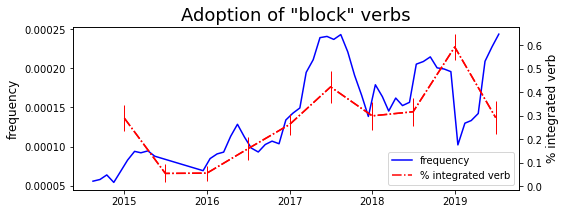

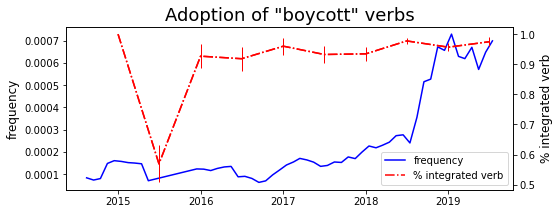

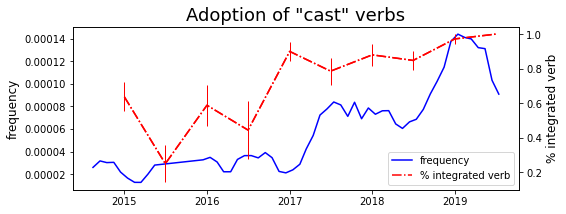

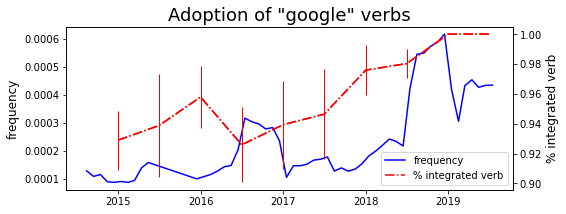

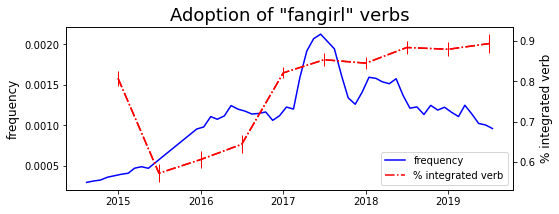

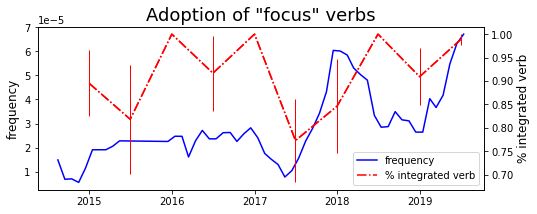

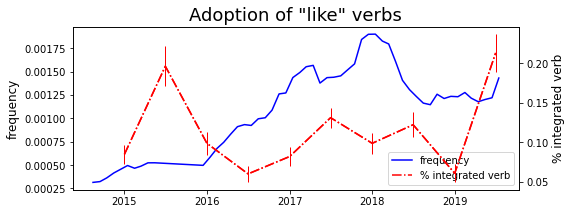

In [31]:
## plot example graphs of growth words with integrated rate pre/post split point
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plot_words = ['block', 'boycott', 'cast', 'google', 'fangirl', 'focus', 'like']
word_var = 'loanword'
date_var = 'date'
month_window_date_var = 'date_6_window'
freq_var = 'smooth_norm_total_verb_count'
integrated_rate_var = 'integrated_verb_rate'
freq_var_name = 'frequency'
integrated_rate_var_name = '% integrated verb'
for word_i in plot_words:
    # count data
    count_data_i = smooth_count_data[smooth_count_data.loc[:, word_var]==word_i]
    # integrated verb rate data
    window_count_data_i = window_count_data[window_count_data.loc[:, word_var]==word_i].dropna(how='any', inplace=False)
    # restrict to data within the same boundary
    min_date_i = count_data_i.loc[:, date_var].min()
    window_count_data_i = window_count_data_i[window_count_data_i.loc[:, month_window_date_var] >= min_date_i]
    valid_window_dates_i = window_count_data_i.loc[:, month_window_date_var]
    err_data_i = err_rate_data[(err_rate_data.loc[:, word_var]==word_i) & (err_rate_data.loc[:, month_window_date_var].isin(valid_window_dates_i))].sort_values(month_window_date_var, ascending=True, inplace=False).loc[:, 'err']
#     split_date_i = word_peak_dates.loc[word_i]
#     host = plt.subplot(111)
    f, ax1 = plt.subplots(figsize=(8,3))
    ax2 = ax1.twinx()
    # plot counts
    line_1 = ax1.plot(count_data_i.loc[:, date_var], count_data_i.loc[:, freq_var], label=freq_var_name, color='b', linestyle='-')
    # plot integrated verb rate
    line_2 = ax2.plot(window_count_data_i.loc[:, month_window_date_var], window_count_data_i.loc[:, integrated_rate_var], label=integrated_rate_var_name, color='r', linestyle='-.')
    ax2.errorbar(x=window_count_data_i.loc[:, month_window_date_var], y=window_count_data_i.loc[:, integrated_rate_var], yerr=err_data_i, color='r', elinewidth=1., linestyle='-.')
    # plot integrated verb rate err
#     ax2.tick_params(axis='y')
    # add line for split point
#     split_date_i = word_peak_dates.loc[word_i]
#     y_max = data_i.loc[:, freq_var].max()
#     y_min = 0.
#     ax1.vlines(split_date_i, y_min, y_max, linestyle='--', color='k')
    # add labels
    ax1.set_ylabel(freq_var_name, fontsize=12)
    ax2.set_ylabel(integrated_rate_var_name, rotation=90, fontsize=12)
    plot_lines = line_1 + line_2
    plot_labels = [l.get_label() for l in plot_lines]
    ax1.legend(plot_lines, plot_labels, loc='lower right')
    plt.title(f'Adoption of "{word_i}" verbs', fontsize=18)
    plt.xlabel('Date', fontsize=12)
    plt.show()

Let's look at the reverse story: do words that *decline* also tend to lose integration?

In [562]:
word_count = smooth_count_data.loc[:, word_var].nunique()
p_val_upper = 0.05 / word_count
decline_words = []
for word_i, data_i in smooth_count_data.groupby(word_var):
    date_timestamp_i = data_i.loc[:, date_var].apply(lambda x: x.timestamp())
    correl, p_val = spearmanr(date_timestamp_i, data_i.loc[:, smooth_count_var])
    if(correl < 0. and p_val < p_val_upper):
        print('word <%s> has decline %.3f (p = %.3E)'%(word_i, correl, p_val))
        decline_words.append(word_i)
print('%d decline words'%(len(decline_words)))

word <crack> has decline -0.485 (p = 2.004E-04)
word <dope> has decline -0.723 (p = 6.803E-10)
word <hypnosis> has decline -0.772 (p = 8.305E-12)
word <love> has decline -0.790 (p = 1.302E-12)
word <rock> has decline -0.681 (p = 1.467E-08)
word <sniff> has decline -0.604 (p = 1.358E-06)
word <stalk> has decline -0.964 (p = 1.372E-31)
word <surf> has decline -0.510 (p = 8.322E-05)
word <text> has decline -0.656 (p = 7.112E-08)
word <zap> has decline -0.664 (p = 4.376E-08)
10 decline words


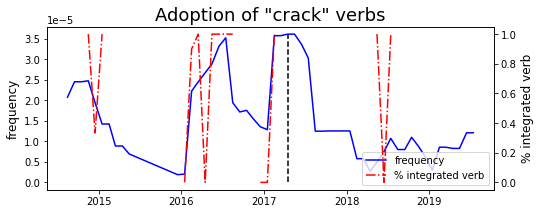

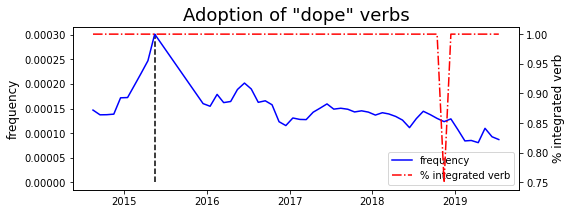

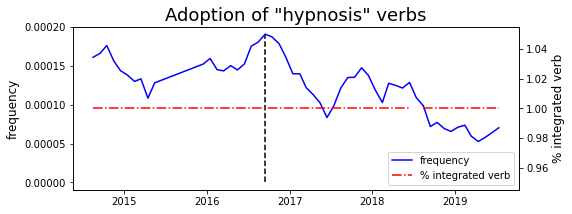

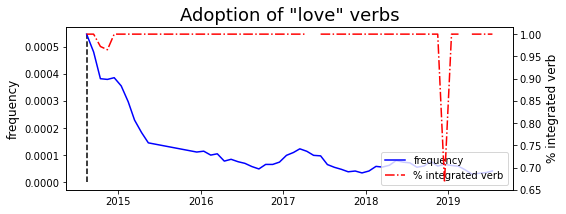

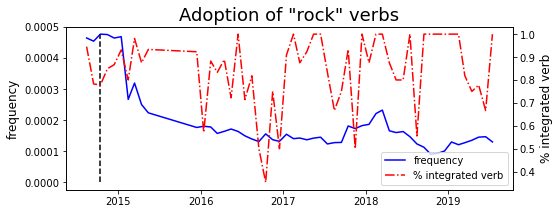

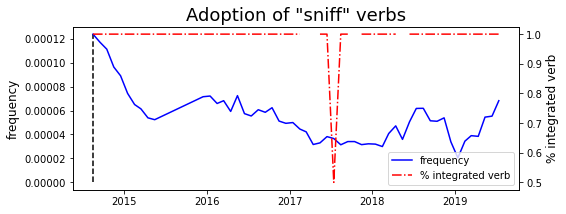

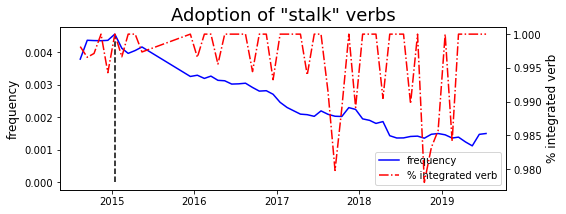

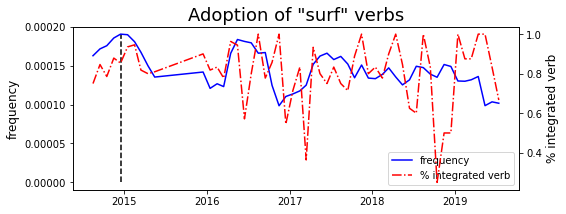

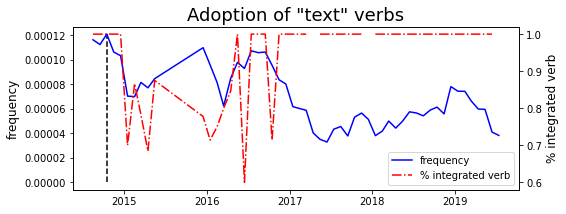

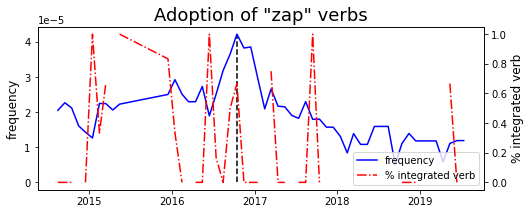

word <crack> has integrated rate diff 0.792 --> 0.552 = -0.240 (test stat = 2.229, p = 1.291E-02)
word <dope> has integrated rate diff 1.000 --> 0.996 = -0.004 (test stat = 1.700, p = 4.454E-02)
word <hypnosis> has integrated rate diff 1.000 --> 1.000 = 0.000 (test stat = nan, p = NAN)
word <love> has integrated rate diff 0.996 --> 0.992 = -0.004 (test stat = 0.666, p = 2.527E-01)
word <rock> has integrated rate diff 0.834 --> 0.888 = 0.053 (test stat = -2.229, p = 1.292E-02)
word <sniff> has integrated rate diff 1.000 --> 0.989 = -0.011 (test stat = 1.620, p = 5.265E-02)
word <stalk> has integrated rate diff 0.998 --> 0.995 = -0.002 (test stat = 2.149, p = 1.581E-02)
word <surf> has integrated rate diff 0.832 --> 0.786 = -0.046 (test stat = 1.553, p = 6.024E-02)
word <text> has integrated rate diff 0.899 --> 1.000 = 0.101 (test stat = -3.236, p = 6.068E-04)
word <zap> has integrated rate diff 0.405 --> 0.250 = -0.155 (test stat = 1.729, p = 4.193E-02)


/hg190/istewart6/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [571]:
for word_i in decline_words:
    data_i = smooth_count_data[smooth_count_data.loc[:, word_var]==word_i]
    split_date_i = word_peak_dates.loc[word_i]
    f, ax1 = plt.subplots(figsize=(8,3))
    ax2 = ax1.twinx()
    # plot counts
    line_1 = ax1.plot(data_i.loc[:, date_var], data_i.loc[:, freq_var], label=freq_var_name, color='b', linestyle='-')
    # plot integrated verb rate
    line_2 = ax2.plot(data_i.loc[:, date_var], data_i.loc[:, integrated_rate_var], label=integrated_rate_var_name, color='r', linestyle='-.')
    # add line for split point
    y_max = data_i.loc[:, freq_var].max()
    y_min = 0.
    ax1.vlines(split_date_i, y_min, y_max, linestyle='--', color='k')
    # add labels
    ax1.set_ylabel(freq_var_name, fontsize=12)
    ax2.set_ylabel(integrated_rate_var_name, rotation=90, fontsize=12)
    plot_lines = line_1 + line_2
    plot_labels = [l.get_label() for l in plot_lines]
    ax1.legend(plot_lines, plot_labels, loc='lower right')
    plt.title(f'Adoption of "{word_i}" verbs', fontsize=18)
    plt.xlabel('Date', fontsize=12)
    plt.show()
# significance tests
p_val_upper = 0.05 / len(decline_words)
for word_i in decline_words:
    data_i = freq_count_data[freq_count_data.loc[:, word_var]==word_i]
    # compare rate before/after midway point
    mid_date_i = data_i.loc[:, date_var].min() + (data_i.loc[:, date_var].max() - data_i.loc[:, date_var].min()) / 2.
    pre_data_i = data_i[data_i.loc[:, date_var] < mid_date_i]
    post_data_i = data_i[data_i.loc[:, date_var] > mid_date_i]
    pre_verb_count_i = pre_data_i.loc[:, verb_count_var].sum()
    post_verb_count_i = post_data_i.loc[:, verb_count_var].sum()
    pre_integrated_verb_rate_i = pre_data_i.loc[:, integrated_count_var].sum() / pre_verb_count_i
    post_integrated_verb_rate_i = post_data_i.loc[:, integrated_count_var].sum() / post_verb_count_i
    integrated_rate_diff_i = post_integrated_verb_rate_i - pre_integrated_verb_rate_i
    test_stat, p_val = binomial_test(pre_integrated_verb_rate_i, post_integrated_verb_rate_i, pre_verb_count_i, post_verb_count_i)
#     if(p_val < p_val_upper):
    print('word <%s> has integrated rate diff %.3f --> %.3f = %.3f (test stat = %.3f, p = %.3E)'%
          (word_i, pre_integrated_verb_rate_i, post_integrated_verb_rate_i, integrated_rate_diff_i, test_stat, p_val))

Similar to before, we see insignificant decreases in general, and only one significant (positive) result.